In [1]:
import numpy as np
from qiskit import *
import math
from qiskit.quantum_info.operators import Operator
from qiskit import QuantumCircuit, QuantumRegister
from sympy import *
from math import pi
from qiskit.circuit import Parameter
%matplotlib inline
from scipy.integrate import odeint

In [2]:
# Visualization packages
from qiskit.visualization import plot_state_city, plot_bloch_vector,plot_histogram
import matplotlib.pyplot as plt

In [3]:
# Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')
backend_vec = Aer.get_backend('statevector_simulator')
backend_uni = Aer.get_backend('unitary_simulator')

In [4]:
# Register circuit (total qubits in the network)
q_1 = QuantumRegister(4)
c_1 = ClassicalRegister(4) 
q_v = QuantumRegister(2)
c_v = ClassicalRegister(2) 
# Register circuit (total qubits in the network)
q_2 = QuantumRegister(3) 
c_2 = ClassicalRegister(3)

In [5]:
#parameters
N_shots = 10240

# Linear Differential Equation Solver

Here I attempt to implement the design of arXiv: 1807.04553 [quant-ph]. They developed an algorithim to solve simple linear differential equations of the form:

$\dot{\vec{x}} = \mathbf{M}\vec{x} + \vec{b}$, 

where the vectors are N-dimensional, $\mathbf{M}$ is a matrix of coefficients and $\vec{b}$ is a vector of coefficients. 

They implemented two cases: $\mathbf{M}/|\mathbf{M}|$ is unitary or if it is non-unitary. Here I will only cover the unitary case since its the simplest and the non-unitary case is practically the same except you have to modify the $\mathbf{M}$ as a sum of unitary matrices.

The solution for the differential equation analytically is 

$\vec{x}(t) = exp\{\mathbf{M}t\}\vec{x}(0) + (exp\{\mathbf{M}t\} - 1)\mathbf{M}^{-1}\vec{b}$.

The Taylor series is given as 


$\vec{x}(t) = \sum_{n = 0}^{k}\frac{(\mathbf{M}t)^{n}}{n!}\vec{x}(0) +\sum_{n = 1}^{k}\frac{\mathbf{M}^{n-1}t^n}{n!}\vec{b}$,

where k is the order approximation of the numerical implementation.

Since we can break down the matrix and vectors into the computation basis due to vector decomposition:

$|x(0)\rangle = \sum_i \frac{x_i(0)}{|\vec{x}(0)|}|i\rangle = \vec{x}(0) \ \ ; \ \ |b\rangle = \sum_i \frac{b_i}{|\vec{b}|}|i\rangle = \vec{b};$ and

$\mathbf{M} = \sum_{i,j} \frac{M_{ij}}{|\mathbf{M}|}|i\rangle \langle j |$. The operation $| \cdot |$ is the norm of the vector/matrix.  Here we will know to normalize the vectors such that $\langle x(0)|x(0)\rangle = 1 $ and $\langle b|b\rangle = 1$

Let's break the equation as
$\vec{x}(t) = \sum_{n = 0}^{k}\sum_{n = 0}^{k}\sum_{i,j}(\frac{t^{n}}{n!}\mathbf{M}^n |x(0)\rangle +\sum_{n = 1}^{k}\frac{t^n}{n!} \mathbf{M}^{n-1}|b\rangle$,

$\vec{x}(t) = \sum_{n = 0}^{k}\sum_{n = 0}^{k}\sum_{i,j}C_n\mathbf{M}'^n |x(0)\rangle + \sum_{n = 1}^{k}D_n\mathbf{M}'^{n-1}|b\rangle,$

where $C_n = \frac{|\vec{x}(0)|(|M|t)^{n}}{n!}$ for n =0, 1, .., k;  $D_n = \frac{|\vec{b}|(|M|t)^{n}}{n!}$ for n = 1, 2, ..., k; $ and M' is a unitary matrix that's been normalized.

Here the normalization will be $(\sqrt{\sum C_n})^2 +  (\sqrt{\sum D_n})^2 = 1$. I will refer C and D as the sum inside the square roots, respectively. The time solution at the jth component of $\vec{x}(t)$ is $x_j(t) = \langle j| x_j(t)\rangle = \sqrt{P(j)}$. We will refer to Figure 1 as our template. There are some revision when we implement in qiskit since qiskit only works if the control is 1 and not zero (which we need). 

Now how do we implement this. We need one ancilla bit, k + 1 work bits and N amount of qubits for the actual vector. The k + 1 work bits acts as a term for each summation of the taylor series. This is to encode the ancilla bit such that $|0\rangle \sum_i \sqrt{C_i} |i\rangle + |1\rangle \sum_j \sqrt{C_j}|j\rangle$. 

The first task is to create $|x(0)\rangle$ and $| b \rangle$). To start, we apply a gate that acts like the Hadamard operator such that 

$V = \begin{pmatrix} C & D \\ D & - C \end{pmatrix}$.

Next we have to implement the work register using cutsom made control gates. We'll need only a vector of $\sqrt{C_i}/C$ and $\sqrt{D_i}/D$, but for this to be represented as a gate the vector has to be a unitary matrix. Luckily we are only worknig on 0 and 1 states such that we can put the vector column at the start or the end of the matrix without caring about the other values of the matrix. For qiskit, the control only applies to the 1 state so we will put this at the end of the custom matrix.

$\mathbf{V}_{s1} = \begin{pmatrix} ... & ... & \frac{\sqrt{C_0}}{C} \\ ... & ... & \frac{\sqrt{C_1}}{C} \\ ... & ... & ... \\ ... & ... & \frac{\sqrt{C_k}}{C}\end{pmatrix}$ 

and 


$\mathbf{V}_{s2} = \begin{pmatrix} ... & ... & \frac{\sqrt{D_1}}{D} \\ ... & ... & \frac{\sqrt{D_2}}{D}  \\ ... & ... & ... \\ ... & ... & \frac{\sqrt{D_k}}{D} \\ ... & ... & 0\end{pmatrix}$. 


$\mathbf{U}_{x}$ is matrix with the components of $x(0)$, and $\mathbf{U}_{b}$ is a matrix with components of $b_i$. These matrices will be applied appropriate according to how qiskit does control gates. 


In [6]:
## Creating a custom circuit
def Vgate(qc,C,D,norm,qr):
    vmat = Operator([
    [C/norm, D/norm],
    [D/norm, -C/norm] ])
    return qc.unitary(vmat, [qr], label='V')


In [21]:
def Vs1gate(qc,C,Cvec,qbc,qb):
    # Only when k = 1
    vs1_circuit = QuantumCircuit(1)
    cx = Operator([
    [np.sqrt(Cvec[0])/C, np.sqrt(Cvec[1])/C],
    [np.sqrt(Cvec[1])/C, -np.sqrt(Cvec[0])/C] 
    ])
    vs1_circuit.unitary(cx, [0], label='Vs1')
    custom = vs1_circuit.to_gate().control(1)
    return qc.append(custom,[qbc,qb])

In [22]:
def Vs2gate(qc,D,dvec,qbc,qb):
    # Only when k = 1
    vs1_circuit = QuantumCircuit(1)
    cx = Operator([
    [np.sqrt(dvec[0])/D, np.sqrt(dvec[1])/D],
    [np.sqrt(dvec[1])/D, -np.sqrt(dvec[0])/D] 
    ])
    vs1_circuit.unitary(cx, [0], label='Vs1')
    custom = vs1_circuit.to_gate().control(1)
    return qc.append(custom,[qbc,qb])

In [23]:
def Vs1conjgate(qc,C,Cvec,qbc,qb):
    # Only when k = 1
    vs1_circuit = QuantumCircuit(1)
    cx = Operator([
    [np.sqrt(Cvec[0])/C, np.sqrt(Cvec[1])/C],
    [np.sqrt(Cvec[1])/C, -np.sqrt(Cvec[0])/C] 
    ])
    vs1_circuit.unitary(cx, [0], label='Vs1')
    custom = vs1_circuit.to_gate().control(1)
    return qc.append(custom,[qbc,qb])

In [24]:
def Vs2conjgate(qc,D,dvec,qbc,qb):
    # Only when k = 1
    vs1_circuit = QuantumCircuit(1)
    cx = Operator([
    [np.sqrt(dvec[0])/D, np.sqrt(dvec[1])/D],
    [np.sqrt(dvec[1])/D, -np.sqrt(dvec[0])/D] 
    ])
    vs1_circuit.unitary(cx, [0], label='Vs1')
    custom = vs1_circuit.to_gate().control(1)
    return qc.append(custom,[qbc,qb])

In [25]:
def Uxgate(qc,xzerovec,j,qbc,qb):
    # Only when k = 1, j = 0,1
    ux1_circuit = QuantumCircuit(1)
    cx = Operator([
    [xzerovec[j]/np.sqrt(2*xzerovec[j]**2), xzerovec[j]/np.sqrt(2*xzerovec[j]**2)],
    [xzerovec[j]/np.sqrt(2*xzerovec[j]**2), -xzerovec[j]/np.sqrt(2*xzerovec[j]**2)] ])
    ux1_circuit.unitary(cx, [0], label='Ux1')
    custom = ux1_circuit.to_gate().control(1)
    return qc.append(custom,[qbc,qb])

In [26]:
def Ubgate(qc,bvec,j,qbc,qb):
    # Only when k = 1, j = 0,1
    ux1_circuit = QuantumCircuit(1)
    #cx = Operator([
    #[bvec[j]/np.sqrt(2*bvec[j]**2), bvec[j]/np.sqrt(2*bvec[j]**2)],
    #[bvec[j]/np.sqrt(2*bvec[j]**2), -bvec[j]/np.sqrt(2*bvec[j]**2)] ])
    #ux1_circuit.unitary(cx, [0])
    custom = ux1_circuit.ry(np.arcsin(bvec[j]),qb).control(1)
    return qc.append(custom,[qbc,qb])

In [27]:
def kth_Mgate(qc,M_mat,k,qbc,qb):
    # Only when k = 1, j = 0,1
    ux1_circuit = QuantumCircuit(1)
    cx = Operator(np.linalg.matrix_power(M_mat,k))
    ux1_circuit.unitary(cx, [0], label='Ub')
    custom = ux1_circuit.to_gate().control(1)
    return qc.append(custom,[qbc,qb])

In [28]:
def CmandDn(t,xnorm,bnorm,Mnorm,m,n):
    C_m = xnorm*(Mnorm*t)**(m)/(math.factorial(m))
    D_n = bnorm*(Mnorm*t)**(n-1)*t/(math.factorial(n))
    return C_m, D_n

In [58]:
def getsol(qc,backend_sim,N_shots,realnorm):
    results = execute(qc,backend = backend_sim,shots = N_shots).result()
    counts = results.get_counts()
    probs = {}
    for output in {'000','100'}:
        if output in counts:
            probs[output] = counts[output]/N_shots# if a count is a 0 or 1 then record the probability 
        else:
            probs[output] = 0
    x_1_t = realnorm**2*probs['000']
    x_2_t = realnorm**2*probs['100']
    return x_1_t,x_2_t

In [59]:
# N-dimensional vector and normalization
xxvec_0 = [1, 0]
M = [[1,1],[1,1]]
bvecu = [1,1]
normx = np.linalg.norm(xxvec_0) 
normb = np.linalg.norm(bvecu) 
normM = np.sqrt(2)#np.linalg.norm(M) 
xvec_0 = xxvec_0/normx
bvec = bvecu/normb 
Mn =[[1/np.sqrt(2),1/np.sqrt(2)],[1/np.sqrt(2),-1/np.sqrt(2)]]

In [82]:
# Work-ancilla register
# k = 1, but the vector should be k + 1 long
k = 1
ts = np.linspace(0.1, 1, 9)
qcsol_x1 = []
qcsol_x2 = []
for tt in ts:
    ccvec = []
    ddvec = []
    m = 0; n = 1
    for qq in range(k+1):
        cm, dm =CmandDn(tt,normx,normb,normM,m,n)
        ccvec.append(cm)
        ddvec.append(dm)
        m = m + 1
        n = n + 1
    ddvec[-1] = 0    
    # Normalize 
    C = np.sqrt(np.sum(ccvec))
    D = np.sqrt(np.sum(ddvec))
    norm = np.sqrt(1/(C**2 + D**2))
    realnorm = np.sqrt(C**2 + D**2)
    ### 2-N dimensional example with only 1 working register
    qc = QuantumCircuit(q_2,c_2)
    qc.initialize([1,0],0)
    qc.initialize([1,0],1)
    qc.initialize([1,0],2)
    Vgate(qc,C,D,realnorm,0)
    qc.x(0)
    Uxgate(qc,xvec_0,0,0,2)
    qc.x(0)
    qc.cry(2*np.arcsin(bvec[0]),0,2)
    qc.x(0)
    Vs1gate(qc,C,ccvec,0,1)
    qc.x(0)
    Vs2gate(qc,D,ddvec,0,1)
    qc.barrier()
    qc.x(1)
    # k= 1
    kth_Mgate(qc,Mn,1,1,2)
    qc.x(1)
    qc.barrier()
    qc.x(0)
    Vs1conjgate(qc,C,ccvec,0,1)
    qc.x(0)
    Vs2conjgate(qc,D,ddvec,0,1)
    Vgate(qc,C,D,realnorm,0)
    qc.barrier()
    qc.measure([2],[2])
    xs1,xs2 = getsol(qc,backend_sim,N_shots,realnorm)
    qcsol_x1.append(xs1)
    qcsol_x2.append(xs2)

In [83]:
def dx_dt(U,t, b1,b2):
    dxdt = [(U[0]+U[1]) + b1,(U[0]-U[1])+b2]
    return dxdt

In [84]:
b1=bvecu[0]; b2=bvecu[1]

sol = odeint(dx_dt, xxvec_0, ts,args = (b1,b2))
xs = sol[:,0]

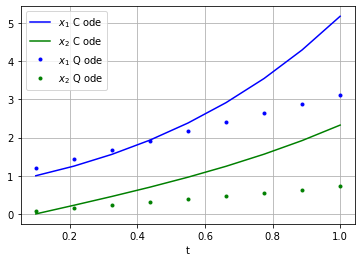

In [86]:
plt.plot(ts, sol[:, 0], 'b', label='$x_1$ C ode')
plt.plot(ts, sol[:, 1], 'g', label='$x_2$ C ode')
plt.plot(ts, qcsol_x1, 'b.', label='$x_1$ Q ode')
plt.plot(ts, qcsol_x2, 'g.', label='$x_2$ Q ode')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

As you can see this is pretty terrible for k = 1. I would say the algorithim works since the first two steps we actually get pretty close to the acutal value with odeint. Its just that you need more working qubits (k $>$ 1$) if you want any hope to get close to a reasonable answer.

In [ ]:
### 2-N dimensional example with only 1 working register

######OLD CODE
#qc = QuantumCircuit(q_1,c_1)
#qc.initialize([1,0],0)
#qc.initialize([1,0],1)
#qc.initialize([1,0],2)
#qc.initialize([1,0],3)
#Vgate(qc,C,D,norm,0)
#qc.x(0)
#Vs1gate(qc,C,ccvec,0,1)
#if xvec_0[0] > 0:
#    Uxgate(qc,xvec_0,0,0,2)
#if xvec_0[1] > 0:
#    Uxgate(qc,xvec_0,1,0,3)
#qc.x(0)
#Vs2gate(qc,D,ddvec,0,1)
#if bvec[0] > 0:
#    Ubgate(qc,bvec,0,0,2)
#if bvec[1] > 0:
#    Ubgate(qc,bvec,1,0,3)
#qc.barrier()
#qc.x(1)
## k= 1
#kth_Mgate(qc,M,0,1,2)
#kth_Mgate(qc,M,1,1,3)
#qc.x(1)
#qc.barrier()
#qc.x(0)
#Vs1conjgate(qc,C,ccvec,0,1)
#qc.x(0)
#Vs2conjgate(qc,D,ddvec,0,1)
#Vgate(qc,C,D,norm,0)
#qc.barrier()
#qc.measure([2,3],[2,3])
#qc.draw('mpl')